L'**apprentissage automatique** (machine learning en anglais) est un champ d'étude de l'intelligence artificielle qui vise à donner aux machines la capacité d'« apprendre » à partir des données via des modèles mathématiques. L'un de ses grands sous-groupes est l'**apprentissage supervisé** où les données passées au modèle sont étiquettés ou labélisées. Autrement dit, le modèle reçoit pour chaque observation un ensemble de caractéristiques et le résultat associé. Lorsque le résultat est une valeur numérique (prix d'un logement, risque de cancer), on parle de **régression**, et lorsqu'il s'agit plutôt de prédire des classes (chien ou chat, client solvable ou non, mail ou spam, espèce de fleur), on parle plutôt de **classification**.

![Exemple de classification](classification.png "Exemple de classification")

Dans cet exemple, nous allons **entraîner un modèle à reconnaître des chiffres écrits à la main**. Ceci n'est qu'une adaptation des traitements explicités au **chapitre 3** de l'ouvrage **Machine Learning avec Scikit-Learn : Mise en œuvre et cas concrets, Ed.2, Aurélien Géron**.

# Les données

Elles représentent l'essence même de la **Data Science** et de l'**Intelligence Artificielle**. C'est la principale ressource utilisée par un **algorithme de machine learning**, celle sur laquelle ce dernier se base pour réaliser ses prédictions. Elles sont en général sous le format dit « rectangulaire » i.e. tableau à deux dimensions (ou matrice) où les lignes représentent les observations et les colonnes les variables.

Nous utiliserons ici le très célèbre jeu de données - le « Hello World! » du Machine Learning - **MNIST** qui est composé de 70 000 petites images de chiffres écrits à la main par des lycéens et des employés des services de recensement américains. L’étiquette associée à chaque image est simplement le chiffre représenté.

Notons qu'il s'agit bien d'un projet de classification, bien que les résultats soient des chiffres. Il n'existe en effet pas de relation d'ordre entre les différents résultats dans ce cas : une image représentant le chiffre 1 *ne vaut pas moins* qu'une autre portant le chiffre 9. On pourrait remplacer les labels par les classes A, B, ..., J, sans affecter les performances du modèle.

In [1]:
# importation du jeu de données
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [2]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
print(X.shape, y.shape)

(70000, 784) (70000,)


Il y'a effectivement **70 000 images** comportant chacune **784 valeurs**, soit 28x28 pixels. Chaque valeur représente l’intensité d’un pixel : de 0 (noir) à 255 (blanc).

Examinons l’un des chiffres de ce jeu de données. Il suffit de récupérer le vecteur des 784 valeurs (ou caractéristiques) d’une observation, de le convertir en matrice de taille 28×28 (pour reconstituer l'image) et de l’afficher.

## Aperçu

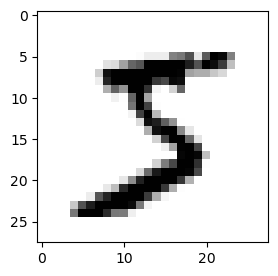

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = np.array(X.loc[0])
some_digit_image = some_digit.reshape(28, 28)
plt.figure(figsize=(3, 3))
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.show()

Ça ressemble à un 5, et c’est bien ce qu’indique l’étiquette :

In [4]:
y.loc[0]

5

Découvrons ensemble les 100 premières images de ce jeu de données :

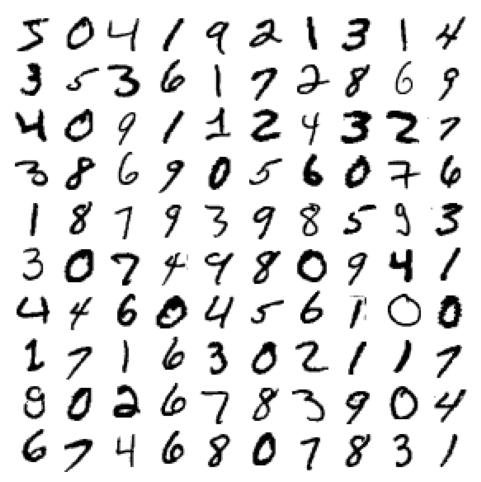

In [5]:
images = np.array(X[:100])
image_grid = images.reshape((10, 10, 28, 28))
big_image = image_grid.transpose(0, 2, 1, 3).reshape(280, 280)

plt.figure(figsize=(6, 6))
plt.imshow(big_image, cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

## Jeu d'entraînement et jeu de test

Un modèle de machine learning ne doit **jamais être évalué sur les mêmes données qui ont servi à son entraînement**. C'est la raison pour laquelle avant tout traitement, on divise toujours le jeu de données en 2 parties : le **train set** et le **test set** (le train set est souvent constitué de 80% des observations tandis que le test set contient les 20% restants). Le modèle sera donc entraîné sur le train set (jeu d'entraînement), puis évalué sur le test set (jeu de test), ce qui permet une mesure objective de la performance étant donné qu'il n'a jamais rencontré ces données.

Dans le cas de MNIST, la division n'est pas effectuée selon le ratio 80/20. Les 60 000 premières observations constituent le train set, et les 10 000 dernières le test set.  

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Le jeu de données étant dès à présent divisé, nous allons procéder à l'entraînement proprement dit du modèle. Pour faire simple, **entraînons un classificateur à detecter les images représentant le chiffre 3**. On aura donc affaire aux deux classes `3` et `pas 3` : un tel classificateur sera qualifié de **binaire** (2 classes). La classe d'intérêt (`3`) est appelée classe **positive**, tandis que l'autre (`pas 3`) est la classe **négative**.

# Entraînement d'un classificateur binaire

Commençons par identifier les images représentant le chiffre 3. La variable `y_train_3` (resp. `y_test_3`) ci-dessous vaut 1 si `y_train = 3` (resp. `y_test = 3`) et 0 sinon.

In [7]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

## Modèle : Forêts aléatoires (Random forests)

Un **arbre de décision** est un outil aidant à la prise d'une décision de classification. Il regroupe sur un même graphique différents choix possibles face à une situation sous la forme de branches d’arbre (d’où son appellation) avec, à chaque extrémité des branches, une décision potentielle.

**Exemple** : Les conditions sont-elles favorables pour jouer au tennis ?

![Arbre de décision](decision_tree.png "Arbre de décision")
    
Le **random forest** ou **forêt aléatoire** est l’un des algorithmes d’apprentissage automatique les plus puissants disponibles à ce jour. Il effectue des tâches de régression aussi bien que de classification, et consiste en l'entraînement de plusieurs arbres de décision. Chaque arbre choisit de manière aléatoire (avec répétition) un certain nombre de lignes et de colonnes pour son entraînement, réduisant ainsi la correlation entre les différents arbres. Pour faire une prédiction, il suffit d’obtenir les prédictions de chacun des arbres, puis de choisir la classe obtenant le plus de votes.

**Note** : Puisque le random forest entraîne chaque arbre sur un sous-ensemble du jeu de données, il n'est pas nécessaire en pratique de diviser le jeu de données en jeu d'entraînement et jeu de test. Nous conserverons toutefois cette division pour l'exemple.

In [8]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

La méthode `fit` permet d'effectuer l'entraînement proprement dit. Elle détermine les paramètres du modèle qui ajustent au mieux les données.

Une fois l'entraînement effectué, la méthode `predict` permet d'effectuer une prédiction sur une donnée.

In [9]:
forest_clf.fit(X_train, y_train_3)

# La première image (le 5 visualisé plus haut) représente-elle un 3?
forest_clf.predict(X[:1])

array([False])

La prédiction ici est correcte ! La première image appartient à la classe des `pas 3`.

Nous pouvons dès à présent nous poser un ensemble de questions : la prédiction sera t-elle correcte pour toutes les données? Comment évaluer notre modèle?

## Mesures de performance

L'évaluation du modèle se fait sur le jeu de test, celui qui a été mis de côté dès le début avant l'entraînement. Notre classifieur n'a jamais eu accès à ces données, il n'a donc pas pu « apprendre » d'elles, ce qui crédibilise davantage les mesures de performance que nous verrons par la suite.

### Matrice de confusion

En apprentissage automatique supervisé, la **matrice de confusion** est une matrice qui mesure la qualité d'un système de classification, elle montre rapidement si celui-ci parvient à effectuer sa tâche correctement.

Dans cette matrice, chaque ligne correspond à une classe réelle et chaque colonne à une classe estimée. La cellule (L, C) contient le nombre d'éléments de la classe réelle L qui ont été classifiés comme étant de la classe C.

In [10]:
# Prédictions sur le test set
y_test_pred = forest_clf.predict(X_test)

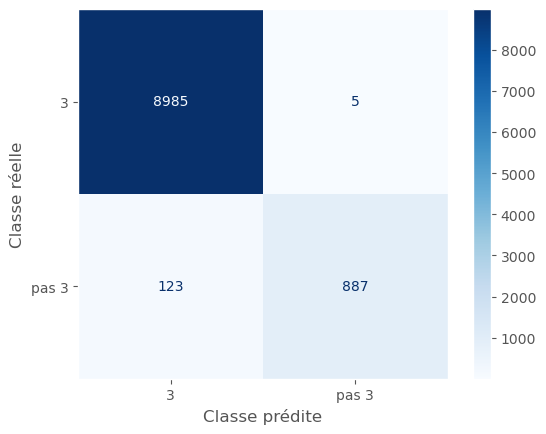

In [11]:
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_3, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['3', 'pas 3']))
disp.plot(cmap='Blues')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.grid(False)
plt.show()

**Rappel** : `3` est la classe **positive**, et `pas 3` la classe **négative**.

**Note** : **Lorsqu'un classificateur a raison**, on dit que sa prédiction est **vraie**, celle-ci est dite **fausse** dans l'autre cas.

Cela paraît évident, mais il est important de le rappeler et de souligner cette différence pour éviter toute ambigüité dans ce qui va suivre.

*Interprétation de la matrice de confusion*

- **8985** `3` ont été classifiés comme étant des 3, on parle alors de **vrais positifs** (la prédiction est correcte et `3` est la vraie classe)
- **5** `3` ont été mal classifiés : **faux négatifs** (la prédiction est incorrecte et `3` est la vraie classe, donc ils sont négatifs à tort)
- **123** `pas 3` ont été classifiés comme étant des 3 : **faux positifs** (vous devriez comprendre maintenant)
- **887** `pas 3` ont été classifiés comme étant des `pas 3` : **vrais négatifs** (...)

On utilisera les abbréviations suivantes :

- $TP$ : nombre de **vrais positifs** (True Positive)
- $FN$ : nombre de **faux négatifs** (False Negative)
- $FP$ : nombre de **faux positifs** (False Positive)
- $TN$ : nombre de **vrais négatifs** (True Négative)

Ceci nous permet d'introduire de nouvelles métriques.

### L'accuracy, la précision et le rappel

- L'**accuracy** mesure l'exactitude des prédictions. On l'obtient en divisant le nombre total de prédictions correctes $TP + TN$ par le nombre total de prédictions $TP + FN + FP + TN$.
$$accuracy = \frac{TP + TN}{TP + FP + FP + TN}$$

- La **précision** mesure l'exactitude des prédictions positives. Autrement dit dans notre cas, elle répond à la question : De tous les `3` détectés par notre modèle ($TP + FP$), combien représentent effectivement le chiffre 3 ($TP$) ? 
$$précision = \frac{TP}{TP + FP}$$

- Le **rappel** (ou la **sensibilité**) évalue les observations positives detectées, elle répond à la question : De toutes les images représentant effectivement le chiffre `3` ($TP + FN$), combien notre modèle a-t-il pu détecter ($TP$) ?
$$rappel = \frac{TP}{TP + FN}$$

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test_3, y_test_pred)
precision = precision_score(y_test_3, y_test_pred)
rappel = recall_score(y_test_3, y_test_pred)

print('Accuracy : {:.2f}%'.format(accuracy*100))
print('Précision : {:.2f}%'.format(precision*100))
print('Rappel : {:.2f}%'.format(rappel*100))

Accuracy : 98.72%
Précision : 99.44%
Rappel : 87.82%


### Compromis précision / rappel

De manière générale :

- une **augmentation de la précision** entraîne une **baisse du rappel**
- une **augmentation du rappel** entraîne une **baisse de la précision**

Pour comprendre ce compromis, nous utiliserons un autre classificateur, le **classificateur de descente de gradient stochastique** (Stochastic Gradient Descent ou SGD Classifier). Relevons la différence majeure entre les deux modèles utilisés afin de justifier ce choix.

Comme précisé plus haut, le random forest utilise plusieurs arbres de décision, et déclare gagnante la classe ayant le plus de votes.

Une autre manière d'opérer une classification binaire - et ça c'est le cas du SGD Classifier - consiste à établir une **frontière de décision** (une droite dans $\mathbb{R}^2$, un plan dans $\mathbb{R}^3$, un hyperplan dans $\mathbb{R}^n$) séparant les deux classes d'observations. Chaque observation sera donc vue comme un point de l'espace se situant d'un côté où de l'autre de la frontière.

Dans ce scénario, chaque « point » se voit alors attribuer un **score** - pour les matheux - qui correspond tout simplement au produit scalaire des **coefficients** de l'équation cartésienne de la frontière de décision et des **coordonnées** du point en question. Un score **positif**, signifie que le classifieur considère l'observation comme étant un `3`, et un score **négatif** représente tout chiffre autre que 3 (d'où les appelations vues plus haut).

*Illustration simple (pour les matheux)*

> Supposons que chaque objet à classifier présente deux caractéristiques $x$ et $y$. Chaque objet peut donc être représenté dans le plan ($\mathbb{R}^2$) grâce à ses coordonnées (ou caractéristiques), et la frontière de décision sera donc une droite dont l'équation cartésienne sera sous la forme $ax + by + c = 0$. Cette droite séparera ainsi les points $(x, y)$ dont le **score** $ax + by + c$ sera supérieur à 0, des points dont le (même) score sera plutôt négatif.

> En y regardant de plus près, ce score correspond bel et bien au produit scalaire du vecteur des **coefficients** $(a, b, c)$ de la droite séparatrice, avec le vecteur des **coordonnées** $(x, y, 1)$ du point (la dernière composante 1 représente le terme d'erreur ou biais) :

$$\begin{bmatrix}a\\b\\c\end{bmatrix} . \begin{bmatrix}x\\y\\1\end{bmatrix} = ax + by + c$$

> C'est ce même processus qui est généralisé dans $\mathbb{R}^n$ (avec n = 784 dans notre cas !)

Partant du principe que notre classificateur n'est pas parfait, il est évident - et nous l'avons vu - que certaines images seront mal classifiées : des `5` pourront par exemple être assimilés à des `3` et avoir un score positif, baissant ainsi (généralement mais pas toujours !) la précision, tandis que certains 3 ressemblant plus à des 8 par exemple auront un score négatif, baissant ainsi (toujours) le rappel.

Il est aussi évident qu'un grand nombre d'erreurs se retrouve « pas très loin » de la frontière de décision (des `3` qui ressembleraient beaucoup à des `2`, des `8` qui ressembleraient beaucoup à des `3`, etc.).

Ansi, **modifier non pas la frontière de décision, mais plutôt le seuil de décision** fixé ici à 0 aurait un impact sur les métriques précédentes :

- Si le seuil est fixé à une valeur négative :
    - davantage de `pas 3` seront pris comme étant des `3` (baisse de la précision)
    - mais aussi il sera plus « difficile » de manquer un vrai `3` (augmentation du rappel)
    
- Si par contre le seuil est fixé à une valeur positive :
    - davantage de `pas 3` seront rejettés (augmentation de la précision)
    - mais aussi il sera plus « facile » de manquer un vrai `3` (baisse du rappel)
    
**Note** : En ce qui concerne la précision, l'augmentation et la baisse ne sont pas automatiques, il existe des cas extrêmes.

Si $S$ est un seuil fixé tel que de vrais positifs ET de faux positifs existent, en notant leur nombre d'occurence respectifs $n_{TP}$ et $n_{FP}$, la précision actuelle vaut :
$$P_1 = \frac{n_{TP}}{n_{TP} + n_{FP}}$$

**En diminuant le seuil** de manière à n'admettre qu'une seule nouvelle image positive, si celle-ci appartient effectivement à cette classe positive, la nouvelle précision devient :
$$P_2 = \frac{n_{TP} + 1}{n_{TP} + 1 + n_{FP}}$$
Et on a :
$$P_1 - P_2 = -n_{FP} < 0 \Rightarrow P_1 < P_2$$
La **précision** a plutôt **augmenté**.

De même, **en augmentant le seuil** de manière à ne laisser sortir qu'une seule image classée positive, si celle-ci appartient effectivement à la classe positive, la nouvelle précision devient :
$$P_3 = \frac{n_{TP} - 1}{n_{TP} - 1 + n_{FP}}$$
Et on a :
$$P_1 - P_3 = n_{FP} > 0 \Rightarrow P_1 > P_3$$
La **précision** a cette fois-ci **baissé**.

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)

# Calcul du score associé à chaque image du jeu de test
y_scores = sgd_clf.decision_function(X_test)

In [14]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test_3, y_scores)

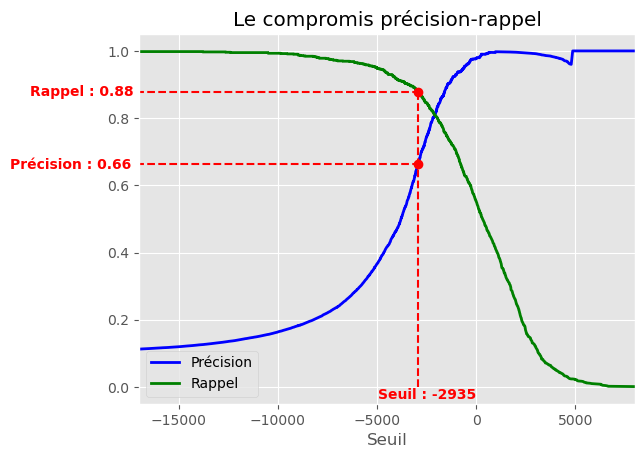

In [15]:
# Courbes de précision et de rappel
plt.plot(thresholds, precisions[:-1], 'b-', linewidth=2, label='Précision')
plt.plot(thresholds, recalls[:-1], 'g-', linewidth=2, label='Rappel')

plt.xlim(-17000, 8000)
plt.xlabel('Seuil')

# Quel seuil choisir pour un rappel d'environ 88% ?
# Quel impact sur la précision ?
recall_90 = np.where((recalls > .879) & (recalls < .881))[0][-1]

# Seuil
plt.plot(thresholds[recall_90], recalls[recall_90], 'ro')
plt.plot(thresholds[recall_90], precisions[recall_90], 'ro')
plt.plot([thresholds[recall_90], thresholds[recall_90]],
         [0, recalls[recall_90]], 'r--')
plt.text(thresholds[recall_90] -2000, -.035,
         'Seuil : {:.0f}'.format(thresholds[recall_90]),
         fontweight='bold', c='r')

# Précision
plt.plot([thresholds[0], thresholds[recall_90]],
         [precisions[recall_90], precisions[recall_90]], 'r--')
plt.text(-17000-6500, 0.65,
         'Précision : {:.2f}'.format(precisions[recall_90]),
         fontweight='bold', c='r')

# Rappel
plt.plot([thresholds[0], thresholds[recall_90]],
         [recalls[recall_90], recalls[recall_90]], 'r--')
plt.text(-17000-5500, 0.865,
         'Rappel : {:.2f}'.format(recalls[recall_90]), fontweight='bold', c='r')

plt.title('Le compromis précision-rappel')
plt.legend()
plt.show()

Il est important de noter que privilégier la précision au rappel et vice-versa dépend du contexte.

Si on entraîne par exemple un classificateur en vue de détecter des vidéos sans danger pour les enfants, l'on préfèrerait probablement un classificateur qui rejette beaucoup de bonnes vidéos (faible rappel) mais conserve uniquement des vidéos sans danger (haute précision) à un classificateur ayant un taux de rappel plus élevé mais laissant passer quelques vidéos vraiment mauvaises.

À l’opposé, si un classificateur est entraîné pour détecter une incendie sur des images de surveillance, l'on pourrait se contenter d'un classificateur renvoyant beaucoup des alertes (faible précision) au lieu de laisser un incendie se développer et tout ravager sur son passage (rappel élevé).

Nous arrivons à la fin de notre mini-projet de classification qui, je le souligne, s'est plutôt réalisé dans le meilleur des mondes. En effet, le schéma n'est pas aussi canonique dans la vraie vie ; entre l'acquisition des données, les questions de quantité et de qualité, les opérations de labellisation et de preprocessing, le choix du meilleur modèle, des meilleurs hyperparamètres, des métriques d'évaluation, ..., il est clair qu'un projet de machine learning c'est beaucoup plus que 3 lignes de code !